In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy import integrate
from scipy import linalg
from scipy import interpolate
from sklearn import gaussian_process as gp
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
from Adam import Adam
from fourier_1d import *
from util import *

In [2]:
f_train = generate(length_scale=0.2)
f_test = generate(samples=100,length_scale=0.2)
new_1 = generate(samples=100,length_scale=2)
new_2 = generate(samples=100,length_scale=0.2,A=10)
new_3 = generate(samples=100,length_scale=2,A=10)
f_test = np.concatenate((f_test,new_1))
f_test = np.concatenate((f_test,new_2))
f_test = np.concatenate((f_test,new_3))
u_train = RK4(0,f_train)
u_test = RK4(0,f_test)
dim = f_train.shape[-1]
f_train = np.delete(f_train,np.linspace(1,dim-2,(dim-1)//2).astype(np.int32).tolist(),-1)
f_test = np.delete(f_test,np.linspace(1,dim-2,(dim-1)//2).astype(np.int32).tolist(),-1)
dim = (dim-1)//2+1
grid = np.linspace(0, 1, dim)
u_0 = np.zeros_like(u_train)
for i in range(u_0.shape[0]):
    u_0[i] = grid
    
f_aug = 1*f_train+10
u_aug = 1*u_train+10*u_0
f_aug = np.concatenate((f_train,f_aug))
u_aug = np.concatenate((u_train,u_aug))


f_train = torch.Tensor(f_train[:,::5])
u_train = torch.Tensor(u_train[:,::5])
f_test = torch.Tensor(f_test[:,::5])
u_test = torch.Tensor(u_test[:,::5])
f_aug = torch.Tensor(f_aug[:,::5])
u_aug = torch.Tensor(u_aug[:,::5])

f_train = torch.reshape(f_train,(f_train.shape[0],f_train.shape[1],1))
f_test = torch.reshape(f_test,(f_test.shape[0],f_test.shape[1],1))
f_aug = torch.reshape(f_aug,(f_aug.shape[0],f_aug.shape[1],1))

grid = grid[::5]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_train, u_train), batch_size=50, shuffle=True)
aug_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_aug, u_aug), batch_size=50, shuffle=True)
test_1_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_test[:100], u_test[:100]), batch_size=1, shuffle=False)
test_2_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_test[100:200], u_test[100:200]), batch_size=1, shuffle=False)
test_3_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_test[200:300], u_test[200:300]), batch_size=1, shuffle=False)
test_4_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_test[300:], u_test[300:]), batch_size=1, shuffle=False)

ntrain = 1000
batch_size = 50
learning_rate = 0.001
epochs = 500
step_size = 50
gamma = 0.5
modes = 16
width = 64

model = FNO1d(modes, width).cuda()
print('Total parameters:',count_params(model))
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

start = default_timer()
myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()
        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
    scheduler.step()
    train_mse /= len(train_loader)
    train_l2 /= ntrain
    t2 = default_timer()
    print('\repoch {:d}/{:d} L2 = {:.6f}, MSE = {:.6f}, using {:.6f}s'.format(ep+1,epochs,train_l2,train_mse,t2-t1), end='', flush=True)

print('Total training time:',default_timer()-start,'s')

index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_1_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
    test_mse /= len(test_1_loader)
    test_l2 /= 100
    print('test error: L2 =', test_l2,', MSE =',test_mse)
    
index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_2_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
    test_mse /= len(test_2_loader)
    test_l2 /= 100
    print('test error: L2 =', test_l2,', MSE =',test_mse)
    
index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_3_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
    test_mse /= len(test_3_loader)
    test_l2 /= 100
    print('test error: L2 =', test_l2,', MSE =',test_mse)
    
index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_4_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
    test_mse /= len(test_4_loader)
    test_l2 /= 100
    print('test error: L2 =', test_l2,', MSE =',test_mse)
    
torch.save(model,'model/fno1_1')

Total parameters: 549569
epoch 500/500 L2 = 0.001633, MSE = 0.000002, using 0.167802sTotal training time: 88.6203131 s
test error: L2 = 0.0022777985280845315 , MSE = 1.6385490558317173e-05
test error: L2 = 0.0027347192558227107 , MSE = 0.00014212119137132717
test error: L2 = 0.43649244725704195 , MSE = 6.4723753738403325
test error: L2 = 0.43540904074907305 , MSE = 6.3167209482193


In [3]:
v0 = np.sin(np.pi*grid)
v1 = v0*2+10
v0 = torch.Tensor(v0)
v1 = torch.Tensor(v1)
v0 = torch.reshape(v0,(1,v0.shape[0],1))
v1 = torch.reshape(v1,(1,v1.shape[0],1))
pred1 = model(v0.cuda()).view(1,-1)[0].cpu().detach().numpy()
pred2 = model(v1.cuda()).view(1,-1)[0].cpu().detach().numpy()

In [4]:
ntrain = f_aug.shape[0]

model = FNO1d(modes, width).cuda()
print('Total parameters:',count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

start = default_timer()

MSE = torch.zeros(epochs)
L2 = torch.zeros(epochs)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in aug_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()
        
        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        
    scheduler.step()
    
    train_mse /= len(aug_loader)
    train_l2 /= ntrain
    t2 = default_timer()
    
    MSE[ep] = train_mse
    L2[ep] = train_l2
    print('\repoch {:d}/{:d} L2 = {:.6f}, MSE = {:.6f}, using {:.6f}s'.format(ep+1,epochs,train_l2,train_mse,t2-t1), end='', flush=True)

print('Total training time:',default_timer()-start,'s')
index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_1_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
    test_mse /= len(test_1_loader)
    test_l2 /= 100
    print('test error: L2 =', test_l2,', MSE =',test_mse)
    
index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_2_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
    test_mse /= len(test_2_loader)
    test_l2 /= 100
    print('test error: L2 =', test_l2,', MSE =',test_mse)
    
index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_3_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
    test_mse /= len(test_3_loader)
    test_l2 /= 100
    print('test error: L2 =', test_l2,', MSE =',test_mse)
    
index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_4_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
    test_mse /= len(test_4_loader)
    test_l2 /= 100
    print('test error: L2 =', test_l2,', MSE =',test_mse)
    
pred3 = model(v0.cuda()).view(1,-1)[0].cpu().detach().numpy()
pred4 = model(v1.cuda()).view(1,-1)[0].cpu().detach().numpy()

Total parameters: 549569
epoch 500/500 L2 = 0.000915, MSE = 0.000007, using 0.340227sTotal training time: 170.5259401 s
test error: L2 = 0.001874392093741335 , MSE = 9.803107788104449e-06
test error: L2 = 0.001652955183526501 , MSE = 1.2817446924009434e-05
test error: L2 = 0.0005818437749985605 , MSE = 2.9817268364809026e-05
test error: L2 = 0.00047916230556438677 , MSE = 1.2736357463722925e-05


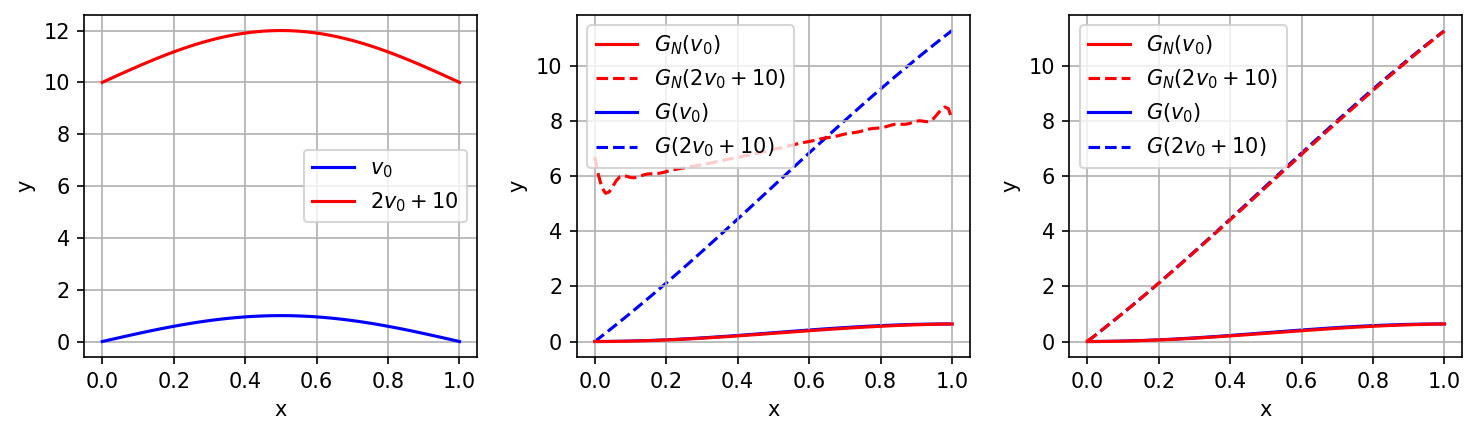

In [5]:
fig = plt.figure(figsize=(10,3), dpi=150)
plt.subplot(1,3,1)
plt.plot(grid,np.sin(np.pi*grid),'b',label='$v_0$')
plt.plot(grid,2*np.sin(np.pi*grid)+10,'r',label='$2v_0+10$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(grid,pred1,'r-',zorder=2,label='$G_N(v_0)$')
plt.plot(grid,pred2,'r--',zorder=2,label='$G_N(2v_0+10)$')
plt.plot(grid,-np.cos(np.pi*grid)/np.pi+1/np.pi,'b-',zorder=1,label='$G(v_0)$')
plt.plot(grid,-2*np.cos(np.pi*grid)/np.pi+2/np.pi+10*grid,'b--',zorder=1,label='$G(2v_0+10)$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(grid,pred3,'r-',zorder=2,label='$G_N(v_0)$')
plt.plot(grid,pred4,'r--',zorder=2,label='$G_N(2v_0+10)$')
plt.plot(grid,-np.cos(np.pi*grid)/np.pi+1/np.pi,'b-',zorder=1,label='$G(v_0)$')
plt.plot(grid,-2*np.cos(np.pi*grid)/np.pi+2/np.pi+10*grid,'b--',zorder=1,label='$G(2v_0+10)$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
fig.savefig('fig_1.png')

In [6]:
torch.save(model,'model/fno1_2')